In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取有噪声图像和背景图像
noisy_left_image = cv2.imread('left_image.png', cv2.IMREAD_GRAYSCALE)
background_left_image = cv2.imread('left.png', cv2.IMREAD_GRAYSCALE)
noisy_right_image = cv2.imread('right_image.png', cv2.IMREAD_GRAYSCALE)
background_right_image = cv2.imread('right.png', cv2.IMREAD_GRAYSCALE)

# 2. 计算差异图
diff_left = cv2.absdiff(noisy_left_image, background_left_image)
diff_right = cv2.absdiff(noisy_right_image, background_right_image)

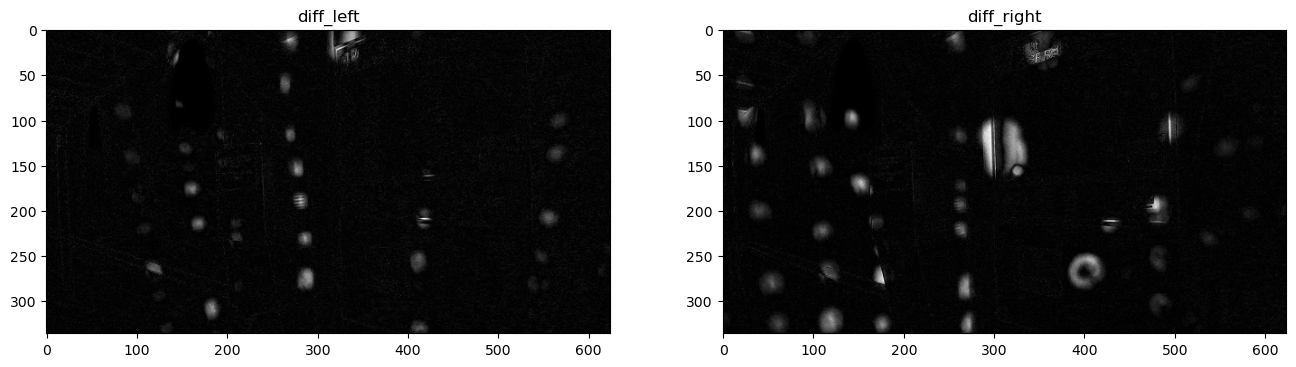

In [3]:
plt.figure(figsize=(16, 12))
plt.subplot(1,2,1)
plt.imshow(diff_left,cmap='gray')
plt.title("diff_left")

plt.subplot(1,2,2)
plt.imshow(diff_right,cmap='gray')
plt.title("diff_right")
plt.show()

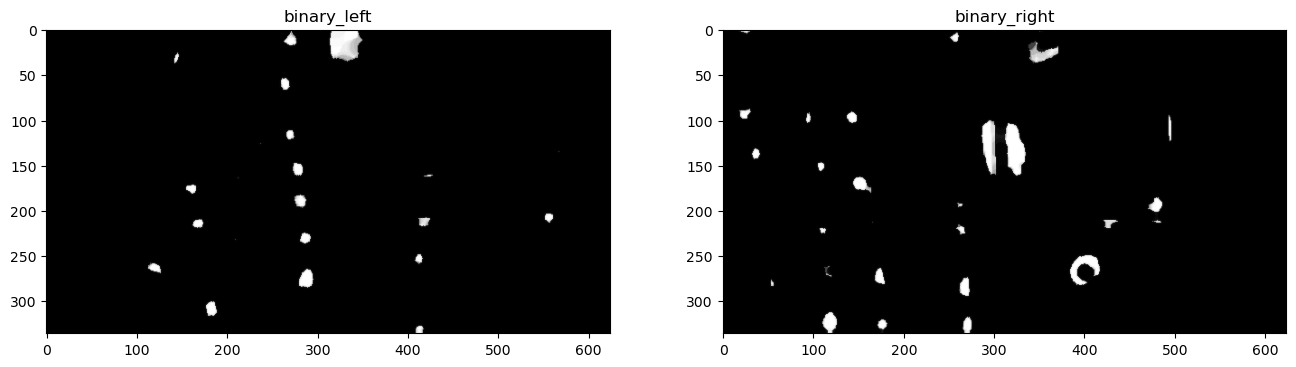

In [4]:
# 3. 二值化处理
_, binary_left = cv2.threshold(diff_left, 20, 255, cv2.THRESH_BINARY)
_, binary_right = cv2.threshold(diff_right, 30, 255, cv2.THRESH_BINARY)

binary_left = cv2.bilateralFilter(binary_left,5,150,150)
binary_right = cv2.bilateralFilter(binary_right,5,150,150)

# 形态学处理
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (21,21))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
binary_left = cv2.morphologyEx(binary_left, cv2.MORPH_CLOSE, kernel1)
binary_right = cv2.morphologyEx(binary_right, cv2.MORPH_CLOSE, kernel2)

plt.figure(figsize=(16, 12))
plt.subplot(1,2,1)
plt.imshow(binary_left,cmap='gray')
plt.title("binary_left")

plt.subplot(1,2,2)
plt.imshow(binary_right,cmap='gray')
plt.title("binary_right")
plt.show()

In [5]:
_, binary_left = cv2.threshold(binary_left, 1, 255, cv2.THRESH_BINARY)
_, binary_right = cv2.threshold(binary_right, 1, 255, cv2.THRESH_BINARY)

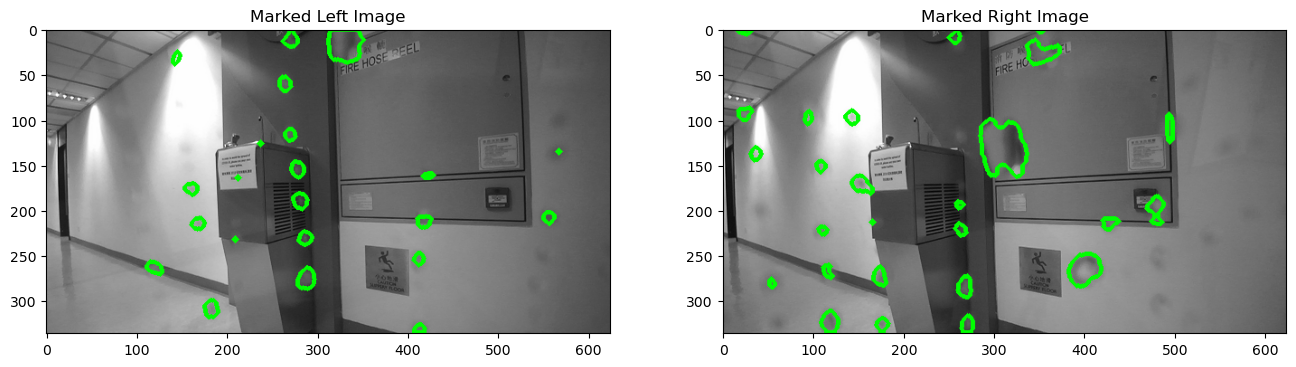

In [6]:
# 4. 查找轮廓
contours_left, _ = cv2.findContours(binary_left, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_right, _ = cv2.findContours(binary_right, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. 在原图上绘制轮廓
marked_left_image = cv2.cvtColor(noisy_left_image, cv2.COLOR_GRAY2BGR)  # 转为彩色图像方便绘制
marked_right_image = cv2.cvtColor(noisy_right_image, cv2.COLOR_GRAY2BGR)

# 画出轮廓
cv2.drawContours(marked_left_image, contours_left, -1, (0, 255, 0), 4)  # 在左图上画轮廓，绿色线
cv2.drawContours(marked_right_image, contours_right, -1, (0, 255, 0), 4)  # 在右图上画轮廓，绿色线

# 6. 显示结果
plt.figure(figsize=(16, 12))

# 左图结果
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(marked_left_image, cv2.COLOR_BGR2RGB))  # 转为RGB显示
plt.title("Marked Left Image")

# 右图结果
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(marked_right_image, cv2.COLOR_BGR2RGB))  # 转为RGB显示
plt.title("Marked Right Image")

plt.show()

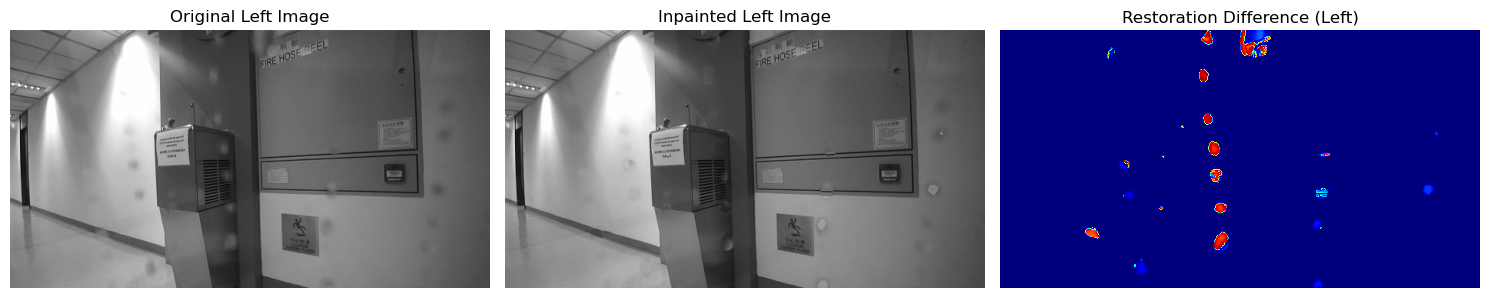

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


left_disp = cv2.imread('disparity.png', cv2.IMREAD_GRAYSCALE)
right_disp = cv2.imread('disparity_r.png', cv2.IMREAD_GRAYSCALE)


def inpaint_noise_with_disparity(left_image, right_image, left_disp, right_disp, binary_left, binary_right):
    """
    修复噪声图像，使用左图和右图的视差图，噪声位置通过噪声掩膜标记
    """
    # 创建恢复后的图像（首先拷贝原图）
    inpainted_left = left_image.copy()
    inpainted_right = right_image.copy()
    
    # 对左图中的噪声区域进行修复
    for u in range(binary_left.shape[0]):
        for v in range(binary_left.shape[1]):
            if binary_left[u, v] == 255:  # 如果是噪声区域
                # 获取左视差值
                left_disp_value = left_disp[u, v]
                # 使用右图的像素修复
                if v - int(left_disp_value) >= 0 and v - int(left_disp_value) < right_image.shape[1]:
                    inpainted_left[u, v] = right_image[u, v - int(left_disp_value)]
    
    # 对右图中的噪声区域进行修复
    for u in range(binary_right.shape[0]):
        for v in range(binary_right.shape[1]):
            if binary_right[u, v] == 255:  # 如果是噪声区域
                # 获取右视差值
                right_disp_value = right_disp[u, v]
                # 使用左图的像素修复
                if v + int(right_disp_value) >= 0 and v + int(right_disp_value) < left_image.shape[1]:
                    inpainted_right[u, v] = left_image[u, v + int(right_disp_value)]
    
    return inpainted_left, inpainted_right

# 修复图像
inpainted_left, inpainted_right = inpaint_noise_with_disparity(noisy_left_image, noisy_right_image, left_disp, right_disp, binary_left, binary_right)

# 可视化恢复效果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(noisy_left_image, cmap='gray')
axes[0].set_title('Original Left Image')
axes[0].axis('off')

axes[1].imshow(inpainted_left, cmap='gray')
axes[1].set_title('Inpainted Left Image')
axes[1].axis('off')

axes[2].imshow(inpainted_left - noisy_left_image, cmap='jet')
axes[2].set_title('Restoration Difference (Left)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [11]:
from skimage.metrics import structural_similarity as ssim

score, _ = ssim(background_left_image, inpainted_left, full=True)
print(f"Left Image SSIM: {np.mean(score):.4f}")

Left Image SSIM: 0.9518


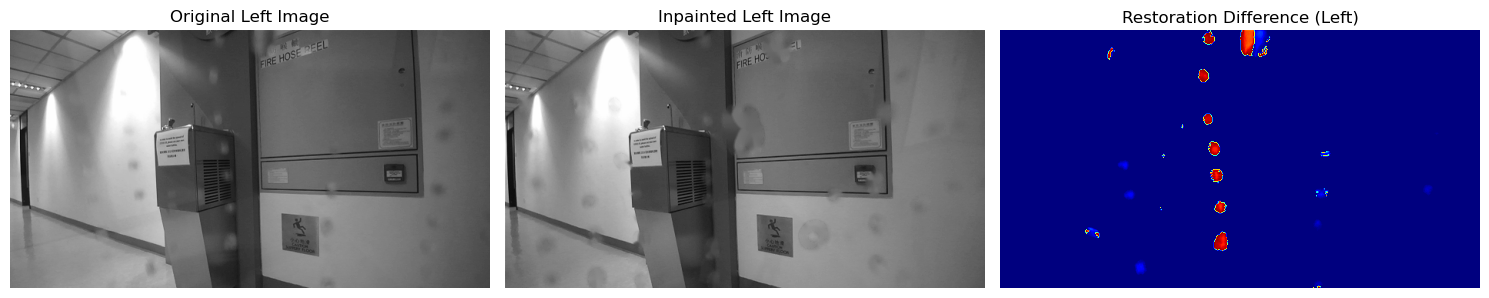

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def refine_inpaint_with_reliability_and_inpainting(left_image, right_image, 
                                                   left_disp, right_disp, 
                                                   binary_left, binary_right,
                                                   max_iter=3, inpainting_radius=3):
    """
    结合对偶图像噪声位置可靠性评估和空白区域恢复策略的图像修复方法。
    """
    # 迭代修复过程
    for _ in range(max_iter):
        # 对左图中的噪声区域进行修复
        for u in range(binary_left.shape[0]):
            for v in range(binary_left.shape[1]):
                if binary_left[u, v] == 255:  # 如果是噪声区域
                    # 获取左视差值
                    left_disp_value = left_disp[u, v]
                    # 使用右图的像素修复，但确保右图对应位置没有噪声
                    if v - int(left_disp_value) >= 0 and v - int(left_disp_value) < right_image.shape[1]:
                        if binary_right[u, v - int(left_disp_value)] == 0:  # 确保右图对应位置没有噪声
                            inpainted_left[u, v] = right_image[u, v - int(left_disp_value)]
        
        # 对右图中的噪声区域进行修复
        for u in range(binary_right.shape[0]):
            for v in range(binary_right.shape[1]):
                if binary_right[u, v] == 255:  # 如果是噪声区域
                    # 获取右视差值
                    right_disp_value = right_disp[u, v]
                    # 使用左图的像素修复，但确保左图对应位置没有噪声
                    if v + int(right_disp_value) >= 0 and v + int(right_disp_value) < left_image.shape[1]:
                        if binary_left[u, v + int(right_disp_value)] == 0:  # 确保左图对应位置没有噪声
                            inpainted_right[u, v] = left_image[u, v + int(right_disp_value)]

    # 修复完毕后，使用OpenCV的inpainting方法进一步填补空白区域
    inpainted_left = cv2.inpaint(inpainted_left, binary_left.astype(np.uint8), inpainting_radius, cv2.INPAINT_TELEA)
    inpainted_right = cv2.inpaint(inpainted_right, binary_right.astype(np.uint8), inpainting_radius, cv2.INPAINT_TELEA)

    return inpainted_left, inpainted_right

# 使用改进后的修复方法
inpainted_left, inpainted_right = refine_inpaint_with_reliability_and_inpainting(noisy_left_image, noisy_right_image, 
                                                                                left_disp, right_disp, 
                                                                                binary_left, binary_right)

# 可视化修复效果
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(noisy_left_image, cmap='gray')
axes[0].set_title('Original Left Image')
axes[0].axis('off')

axes[1].imshow(inpainted_right, cmap='gray')
axes[1].set_title('Inpainted Left Image')
axes[1].axis('off')

axes[2].imshow(inpainted_left - noisy_left_image, cmap='jet')
axes[2].set_title('Restoration Difference (Left)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [79]:
from skimage.metrics import structural_similarity as ssim

score, _ = ssim(background_right_image, inpainted_right, full=True)
print(f"Left Image SSIM: {np.mean(score):.4f}")

Left Image SSIM: 0.9348


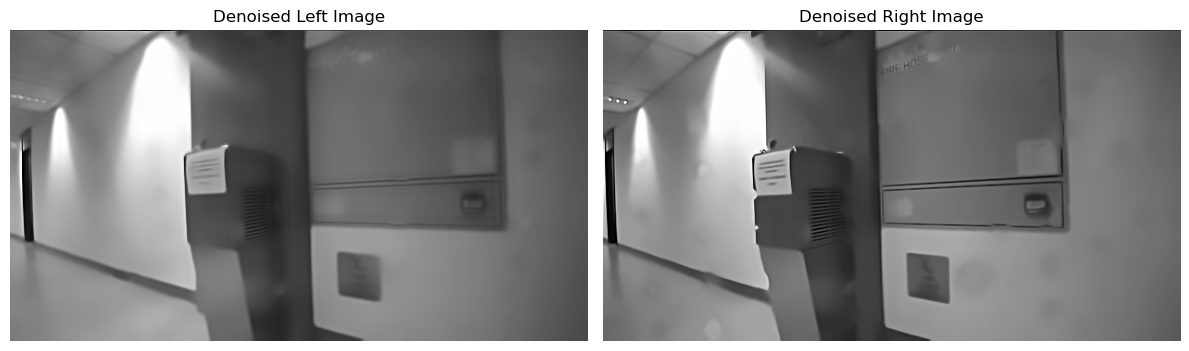

In [92]:
import cv2

# 使用非局部均值去噪
denoised_left = cv2.fastNlMeansDenoising(inpainted_left, None, 30, 7, 21)
denoised_right = cv2.fastNlMeansDenoising(inpainted_right, None, 20, 7, 21)

# 锐化图像（Unsharp Masking）
sharpened_left = cv2.addWeighted(denoised_left, 1.5, cv2.GaussianBlur(denoised_left, (0, 0), 3), -0.5, 0)
sharpened_right = cv2.addWeighted(denoised_right, 1.5, cv2.GaussianBlur(denoised_right, (0, 0), 3), -0.5, 0)

# 可视化去噪后的图像
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(sharpened_left, cmap='gray')
axes[0].set_title('Denoised Left Image')
axes[0].axis('off')

axes[1].imshow(sharpened_right, cmap='gray')
axes[1].set_title('Denoised Right Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()